# Convolutional Variational Autoencoder

# Import libraries

In [1]:
import os
from glob import glob
from utils.custom_utils import RetrieveData, show_images
import random as rd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Download data

In [2]:
DataURL='https://tinyurl.com/mr2yc5nx'

RetrieveData(DataURL)

## Dataloader and data check

In [3]:
image_path='./data/images_gz2/images'

In [4]:
class GalaxyZoo2(Dataset):
    def __init__(self, img_dir, transform=None, train=None, dataset_size=None):
        self.transform = transform
        self.img_dir = img_dir
        
        images = glob(os.path.join(img_dir,'*.jpg'))
        rd.shuffle(images)
        images=images[:dataset_size]
        
        cut = int(0.6*len(images))
        if train==True:
            self.images = images[:cut]
        elif train==False:
            self.images = images[cut:]
        else:
            self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = self.images[index]
        with Image.open(img_path) as im:
            if self.transform:
                im = self.transform(im)
            return im/255

In [5]:
trainset=GalaxyZoo2(image_path, transform=transforms.PILToTensor(), dataset_size=1000)

In [6]:
trainloader=DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

torch.Size([16, 3, 424, 424])


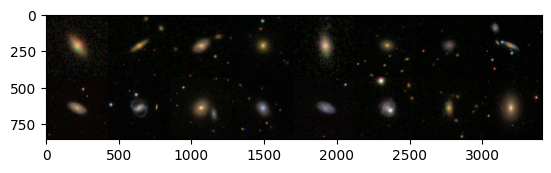

In [7]:
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

## VAE

In [8]:
class Conv_VAE(nn.Module):
    def __init__(self,channels=3, featureDim=32*103*103,latent_dim=2):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Conv2d(channels, 16, 5),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(16, 32, 5),
                                     nn.MaxPool2d(2),
                                     nn.ReLU(),
                                     nn.Flatten(),
                                    )
        
        self.mu = nn.Linear(featureDim, latent_dim)
        self.logvar = nn.Linear(featureDim, latent_dim)
        
        self.latent_mapping = nn.Linear(latent_dim, featureDim)
        
        self.decoder = nn.Sequential(nn.Unflatten(-1,(32,103,103)),
                                     nn.ReLU(),
                                     nn.Upsample(scale_factor=2),
                                     nn.ConvTranspose2d(32, 16, 5),
                                     nn.ReLU(),
                                     nn.Upsample(scale_factor=2),
                                     nn.ConvTranspose2d(16, channels, 5),
                                    )
    
    def encode(self, x):
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        return torch.sigmoid(out)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar

In [9]:
def ElboLoss(x, x_reconstructed, mu, sigma, alpha=1):
    criterion = F.binary_cross_entropy(x_reconstructed, x)
    KL_div = -0.5*torch.sum(1+sigma-mu**2-torch.exp(sigma))
    elbo = torch.mean(criterion + alpha * KL_div)
    return elbo

## Training

In [10]:
def train_Conv(num_epochs, alpha=1):
    """
    Train the model (VAE) onto the data in the trainloader
    """
    train_avg_loss = []
    
    
    for i in range(num_epochs):
        train_losses = []
        loop = tqdm(enumerate(trainloader))
        
        for i,x in loop:
            x = x.to(device)
            x_reconstructed, mu, logvar = model(x)
        
            loss = ElboLoss(x, x_reconstructed, mu, logvar, alpha=alpha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
            train_losses.append(loss.detach())
                    
        train_avg_loss.append(torch.mean(torch.FloatTensor(train_losses)))

    return train_avg_loss #we could also return the reconstruction loss and the regularization loss individually, but in the end it is the ELBO loss that is important

## Model 2

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'this instance use {device}')

torch.manual_seed(100)


image_size = 424
channels = 3
batch_size = 32

learning_rate = 3e-4 # arbitrary
num_epochs = 10 # arbitrary

model_name='Conv_VAE_2'

this instance use cuda


In [12]:
trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=10000)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
model = Conv_VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
train_avg_loss = train_Conv(10,alpha=1e-6)

188it [00:26,  7.22it/s, loss=0.14] 
188it [00:20,  9.13it/s, loss=0.13] 
188it [00:20,  9.12it/s, loss=0.158]
188it [00:20,  9.01it/s, loss=0.159]
188it [00:21,  8.88it/s, loss=0.136]
188it [00:22,  8.50it/s, loss=0.127]
188it [00:20,  9.01it/s, loss=0.142]
188it [00:20,  8.97it/s, loss=0.141]
188it [00:21,  8.93it/s, loss=0.126]
188it [00:21,  8.91it/s, loss=0.163]


In [15]:
torch.save(model, os.path.join('models',model_name+'.pt'))

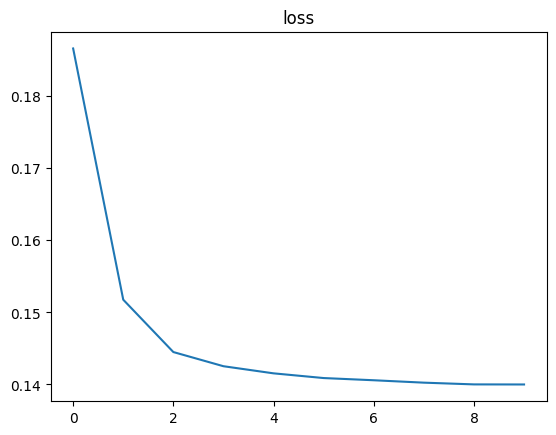

In [21]:
plt.plot(train_avg_loss)
plt.title('loss')
plt.show()

In [17]:
model=model.to('cpu')

In [18]:
testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=1000)
testloader = DataLoader(testset,batch_size=batch_size, shuffle=True, num_workers=2)

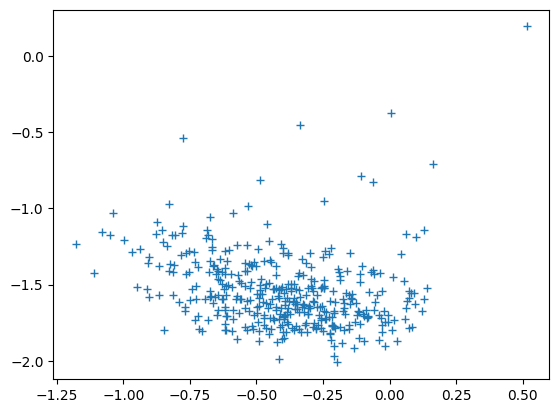

In [19]:
mus=[]
sigmas=[]
for testimages in iter(testloader):

    testmu,testsigma=model.encode(testimages)
    mus.append(testmu.detach().numpy())
    sigmas.append(testsigma.detach().numpy())
mus=np.concatenate(mus)
sigmas=np.concatenate(sigmas)
plt.plot(mus[:,0],mus[:,1],'+')
plt.show()

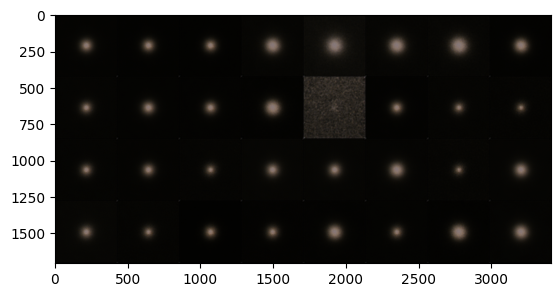

In [20]:
testimage=next(iter(testloader))
    
testmu,testlogvar=model.encode(testimage)
new_z=model.sample_z(testmu,testlogvar)
newimage=model.decode(new_z)
show_images(utils.make_grid(newimage))

## Test on Batch_size

In [27]:
losses=[]

for batch_size in (8,16,32,64):
    print(batch_size)
    torch.cuda.empty_cache()
    
    trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=10000)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    model = Conv_VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_avg_loss = train_Conv(10,alpha=1e-6)
    losses.append(train_avg_loss)
    
    torch.save(model, os.path.join('models',f'{model_name}_batch_size_{batch_size}.pt'))

8


750it [00:42, 17.61it/s, loss=0.146]
750it [00:52, 14.21it/s, loss=0.129]
750it [00:24, 31.12it/s, loss=0.167]
750it [00:23, 31.30it/s, loss=0.139]
750it [00:24, 31.15it/s, loss=0.135]
750it [01:06, 11.34it/s, loss=0.134]
750it [00:26, 28.15it/s, loss=0.131]
750it [00:23, 31.40it/s, loss=0.122]
750it [00:25, 29.80it/s, loss=0.137]
750it [00:24, 30.14it/s, loss=0.139]


16


375it [00:23, 15.79it/s, loss=0.143]
375it [00:22, 16.75it/s, loss=0.146]
375it [00:22, 16.73it/s, loss=0.142]
375it [00:23, 16.25it/s, loss=0.129]
375it [00:22, 16.74it/s, loss=0.142]
375it [00:22, 16.88it/s, loss=0.15] 
375it [00:22, 16.88it/s, loss=0.147]
375it [00:22, 16.90it/s, loss=0.128]
375it [00:22, 16.62it/s, loss=0.123]
375it [00:22, 16.59it/s, loss=0.151]


32


188it [00:21,  8.72it/s, loss=0.162]
188it [00:20,  8.95it/s, loss=0.152]
188it [00:21,  8.88it/s, loss=0.143]
188it [00:21,  8.84it/s, loss=0.121]
188it [00:21,  8.72it/s, loss=0.143]
188it [00:21,  8.81it/s, loss=0.132]
188it [00:21,  8.80it/s, loss=0.131]
188it [00:21,  8.83it/s, loss=0.153]
188it [00:21,  8.84it/s, loss=0.129]
188it [00:21,  8.62it/s, loss=0.126]


64


94it [00:21,  4.28it/s, loss=0.18] 
94it [00:21,  4.38it/s, loss=0.168]
94it [00:21,  4.36it/s, loss=0.15] 
94it [00:21,  4.35it/s, loss=0.145]
94it [00:21,  4.39it/s, loss=0.139]
94it [00:21,  4.43it/s, loss=0.137]
94it [00:23,  4.06it/s, loss=0.147]
94it [00:21,  4.43it/s, loss=0.143]
94it [00:21,  4.38it/s, loss=0.132]
94it [00:21,  4.38it/s, loss=0.137]


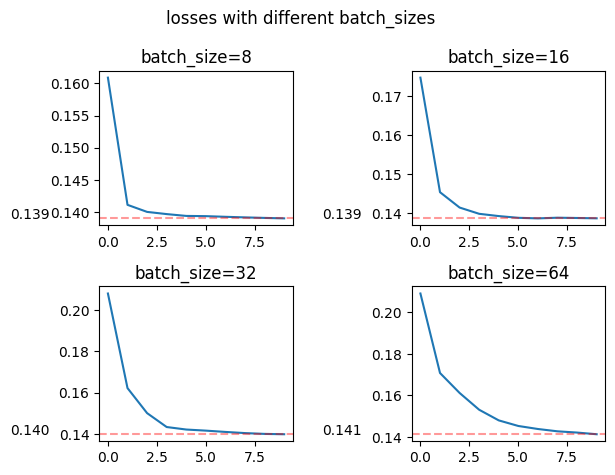

In [28]:
for i, batch_size in zip(range(4),(8,16,32,64)):
    plt.subplot(221+i)
    plt.plot(losses[i])
    plt.axhline(y = losses[i][-1], color = 'r', linestyle = '--', alpha=0.4)
    plt.text(-5,losses[i][-1],f'{losses[i][-1]:.3f}')
    plt.title(f'batch_size={batch_size}')
plt.suptitle('losses with different batch_sizes')
plt.tight_layout()
plt.show()

8


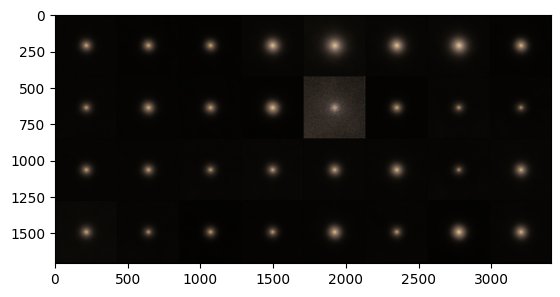

16


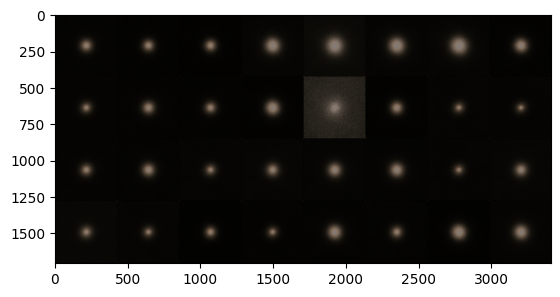

32


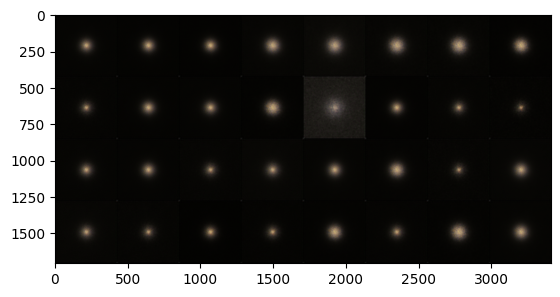

64


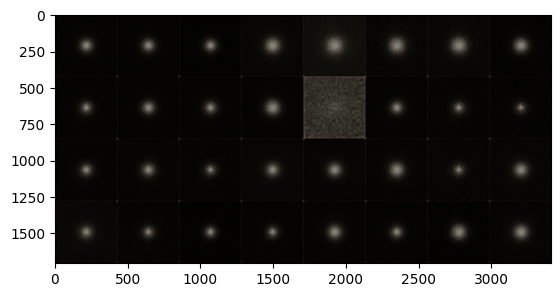

In [29]:
for batch_size in (8,16,32,64):
    model=torch.load(os.path.join('models',f'{model_name}_batch_size_{batch_size}.pt')).to('cpu')
    
    testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=10000)
    testloader = DataLoader(testset,batch_size=1, shuffle=True, num_workers=2)
    
    testimages=next(iter(testloader))    
    print(batch_size)
    testmu,testlogvar=model.encode(testimage)
    new_z=model.sample_z(testmu,testlogvar)
    newimage=model.decode(new_z)
    show_images(utils.make_grid(newimage))

## Test on latent_dim

In [23]:
losses=[]

for latent_dim in (2,4,6,8,10,12):
    print(latent_dim)
    torch.cuda.empty_cache()
    
    trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=10000)
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
    
    model = Conv_VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_avg_loss = train_Conv(10,alpha=1e-6)
    losses.append(train_avg_loss)
    
    torch.save(model, os.path.join('models',f'{model_name}_latent_dim_{latent_dim}.pt'))

2


188it [00:21,  8.79it/s, loss=0.162]
188it [00:21,  8.90it/s, loss=0.142]
188it [00:20,  9.02it/s, loss=0.147]
188it [00:20,  9.01it/s, loss=0.153]
188it [00:20,  9.03it/s, loss=0.142]
188it [00:21,  8.82it/s, loss=0.152]
188it [00:22,  8.40it/s, loss=0.141]
188it [00:21,  8.74it/s, loss=0.132]
188it [00:21,  8.92it/s, loss=0.128]
188it [00:21,  8.83it/s, loss=0.139]


4


188it [00:21,  8.81it/s, loss=0.158]
188it [00:21,  8.80it/s, loss=0.149]
188it [00:21,  8.72it/s, loss=0.14] 
188it [00:21,  8.88it/s, loss=0.139]
188it [00:21,  8.78it/s, loss=0.137]
188it [00:21,  8.93it/s, loss=0.138]
188it [00:21,  8.93it/s, loss=0.136]
188it [00:21,  8.84it/s, loss=0.126]
188it [00:21,  8.88it/s, loss=0.144]
188it [00:21,  8.84it/s, loss=0.146]


6


188it [00:21,  8.66it/s, loss=0.148]
188it [00:21,  8.81it/s, loss=0.146]
188it [00:21,  8.73it/s, loss=0.13] 
188it [00:21,  8.62it/s, loss=0.141]
188it [00:21,  8.75it/s, loss=0.146]
188it [00:21,  8.82it/s, loss=0.131]
188it [00:21,  8.79it/s, loss=0.119]
188it [00:21,  8.80it/s, loss=0.133]
188it [00:22,  8.28it/s, loss=0.156]
188it [00:21,  8.75it/s, loss=0.125]


8


188it [00:21,  8.61it/s, loss=0.148]
188it [00:21,  8.79it/s, loss=0.133]
188it [00:21,  8.80it/s, loss=0.128]
188it [00:21,  8.79it/s, loss=0.15] 
188it [00:21,  8.62it/s, loss=0.137]
188it [00:21,  8.65it/s, loss=0.149]
188it [00:21,  8.67it/s, loss=0.134]
188it [00:21,  8.77it/s, loss=0.138]
188it [00:21,  8.71it/s, loss=0.131]
188it [00:22,  8.32it/s, loss=0.141]


10


188it [00:21,  8.55it/s, loss=0.139]
188it [00:21,  8.73it/s, loss=0.148]
188it [00:21,  8.72it/s, loss=0.135]
188it [00:21,  8.68it/s, loss=0.168]
188it [00:21,  8.67it/s, loss=0.148]
188it [00:22,  8.53it/s, loss=0.152]
188it [00:21,  8.68it/s, loss=0.15] 
188it [00:21,  8.73it/s, loss=0.129]
188it [00:21,  8.74it/s, loss=0.142]
188it [00:21,  8.64it/s, loss=0.144]


12


188it [00:22,  8.19it/s, loss=0.162]
188it [00:21,  8.60it/s, loss=0.168]
188it [00:21,  8.68it/s, loss=0.137]
188it [00:21,  8.62it/s, loss=0.135]
188it [00:21,  8.72it/s, loss=0.138]
188it [00:21,  8.62it/s, loss=0.14] 
188it [00:24,  7.68it/s, loss=0.142]
188it [00:21,  8.71it/s, loss=0.137]
188it [00:21,  8.67it/s, loss=0.137]
188it [00:21,  8.58it/s, loss=0.131]


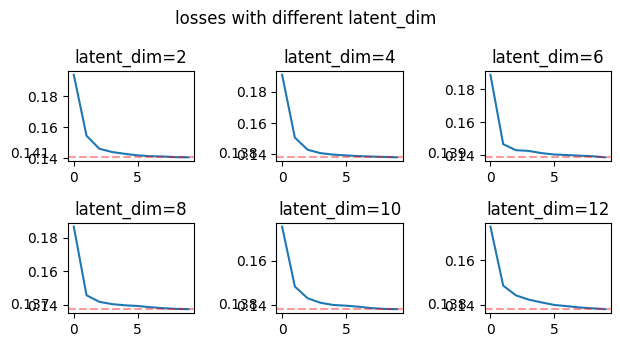

In [24]:
for i, latent_dim in zip(range(6),(2,4,6,8,10,12)):
    plt.subplot(331+i)
    plt.plot(losses[i])
    plt.axhline(y = losses[i][-1], color = 'r', linestyle = '--', alpha=0.4)
    plt.text(-5,losses[i][-1],f'{losses[i][-1]:.3f}')
    plt.title(f'latent_dim={latent_dim}')
plt.suptitle('losses with different latent_dim')
plt.tight_layout()
plt.show()

2


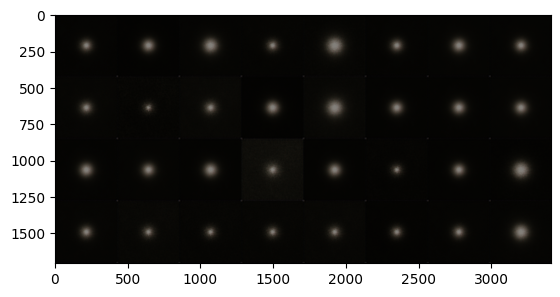

4


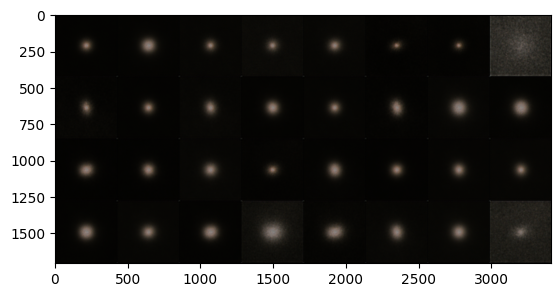

6


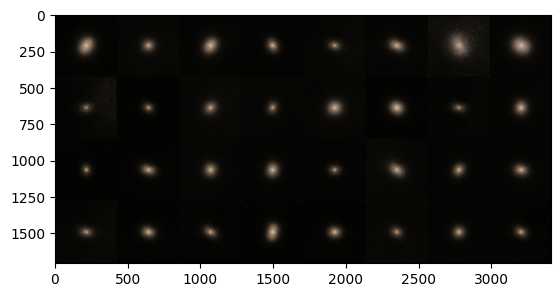

8


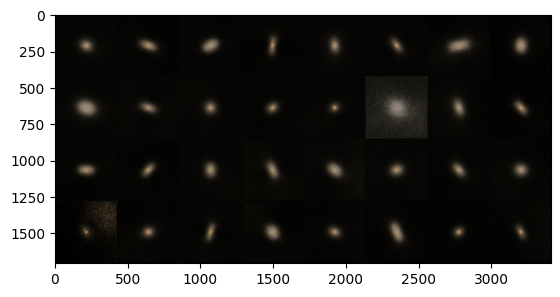

10


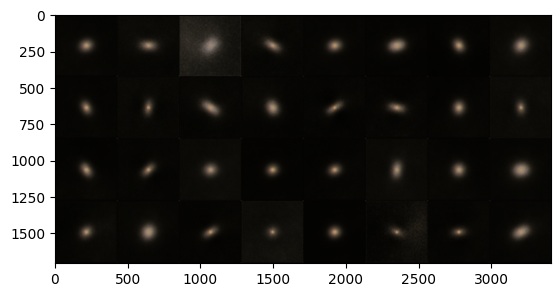

12


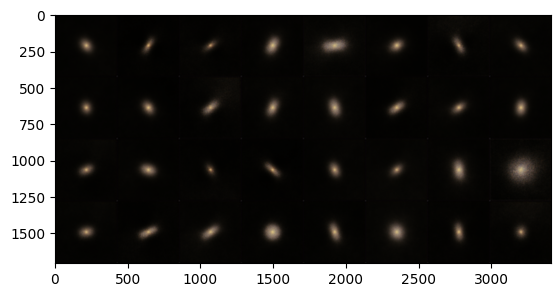

In [25]:
for latent_dim in (2,4,6,8,10,12):
    model=torch.load(os.path.join('models',f'{model_name}_latent_dim_{latent_dim}.pt')).to('cpu')
    
    testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=10000)
    testloader = DataLoader(testset,batch_size=32, shuffle=True, num_workers=2)
    
    testimages=next(iter(testloader))    
    print(latent_dim)
    testmu,testlogvar=model.encode(testimages)
    new_z=model.sample_z(testmu,testlogvar)
    newimage=model.decode(new_z)
    show_images(utils.make_grid(newimage))

## Test on alpha

In [37]:
losses=[]

for alpha in (1,1e-1,1e-2,1e-4,1e-6,1e-7):
    print(alpha)
    torch.cuda.empty_cache()
    
    trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=10000)
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
    
    model = Conv_VAE(latent_dim=12).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_avg_loss = train_Conv(10,alpha=alpha)
    losses.append(train_avg_loss)
    
    torch.save(model, os.path.join('models',f'{model_name}_alpha_{alpha}.pt'))

1


188it [00:22,  8.21it/s, loss=0.153]
188it [00:22,  8.39it/s, loss=0.15] 
188it [00:22,  8.45it/s, loss=0.137]
188it [00:22,  8.51it/s, loss=0.141]
188it [00:22,  8.48it/s, loss=0.173]
188it [00:22,  8.48it/s, loss=0.165]
188it [00:22,  8.33it/s, loss=0.157]
188it [00:22,  8.46it/s, loss=0.133]
188it [00:22,  8.48it/s, loss=0.126]
188it [00:22,  8.50it/s, loss=0.168]


0.1


188it [00:22,  8.31it/s, loss=0.156]
188it [00:22,  8.43it/s, loss=0.163]
188it [00:22,  8.35it/s, loss=0.15] 
188it [00:22,  8.34it/s, loss=0.143]
188it [00:22,  8.44it/s, loss=0.132]
188it [00:22,  8.45it/s, loss=0.137]
188it [00:22,  8.34it/s, loss=0.152]
188it [00:22,  8.47it/s, loss=0.152]
188it [00:21,  8.58it/s, loss=0.162]
188it [00:22,  8.39it/s, loss=0.143]


0.01


188it [00:22,  8.36it/s, loss=0.151]
188it [00:22,  8.54it/s, loss=0.168]
188it [00:22,  8.37it/s, loss=0.145]
188it [00:22,  8.51it/s, loss=0.155]
188it [00:21,  8.56it/s, loss=0.179]
188it [00:22,  8.41it/s, loss=0.151]
188it [00:22,  8.39it/s, loss=0.133]
188it [00:22,  8.49it/s, loss=0.156]
188it [00:22,  8.35it/s, loss=0.158]
188it [00:22,  8.50it/s, loss=0.147]


0.0001


188it [00:22,  8.25it/s, loss=0.138]
188it [00:22,  8.46it/s, loss=0.144]
188it [00:21,  8.57it/s, loss=0.133]
188it [00:22,  8.37it/s, loss=0.142]
188it [00:22,  8.47it/s, loss=0.135]
188it [00:22,  8.53it/s, loss=0.15] 
188it [00:22,  8.40it/s, loss=0.17] 
188it [00:21,  8.56it/s, loss=0.147]
188it [00:22,  8.47it/s, loss=0.138]
188it [00:22,  8.50it/s, loss=0.133]


1e-06


188it [00:24,  7.56it/s, loss=0.134]
188it [00:21,  8.60it/s, loss=0.139]
188it [00:21,  8.63it/s, loss=0.138]
188it [00:22,  8.31it/s, loss=0.161]
188it [00:22,  8.35it/s, loss=0.153]
188it [00:22,  8.46it/s, loss=0.123]
188it [00:22,  8.50it/s, loss=0.133]
188it [00:21,  8.57it/s, loss=0.141]
188it [00:22,  8.44it/s, loss=0.133]
188it [00:23,  7.93it/s, loss=0.148]


1e-07


188it [00:22,  8.36it/s, loss=0.141]
188it [00:22,  8.52it/s, loss=0.139]
188it [00:22,  8.52it/s, loss=0.126]
188it [00:22,  8.41it/s, loss=0.162]
188it [00:22,  8.36it/s, loss=0.146]
188it [00:22,  8.49it/s, loss=0.125]
188it [00:21,  8.63it/s, loss=0.137]
188it [00:22,  8.54it/s, loss=0.16] 
188it [00:22,  8.50it/s, loss=0.154]
188it [00:22,  8.42it/s, loss=0.123]


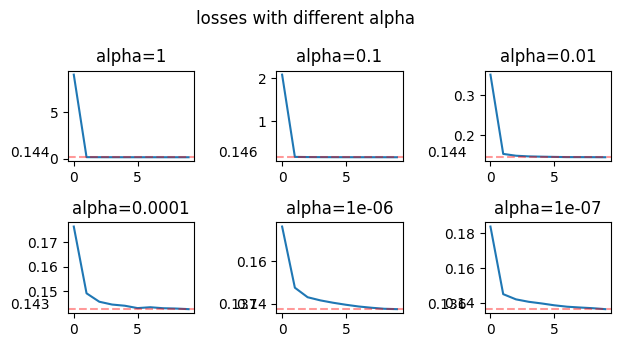

In [38]:
for i, alpha in zip(range(8),(1,1e-1,1e-2,1e-4,1e-6,1e-7)):
    plt.subplot(331+i)
    plt.plot(losses[i])
    plt.axhline(y = losses[i][-1], color = 'r', linestyle = '--', alpha=0.4)
    plt.text(-5,losses[i][-1],f'{losses[i][-1]:.3f}')
    plt.title(f'alpha={alpha}')
plt.suptitle('losses with different alpha')
plt.tight_layout()
plt.show()

1


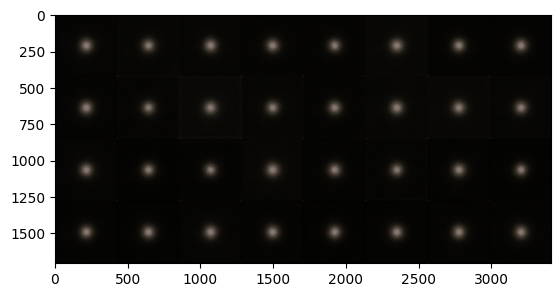

0.1


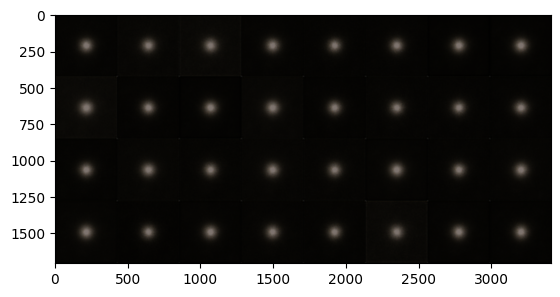

0.01


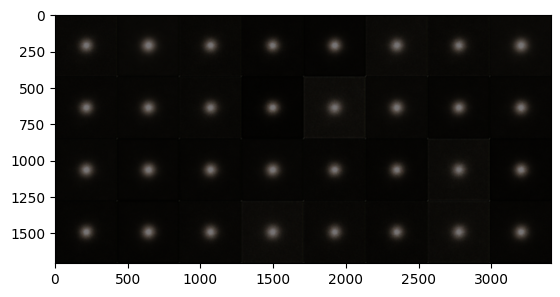

0.0001


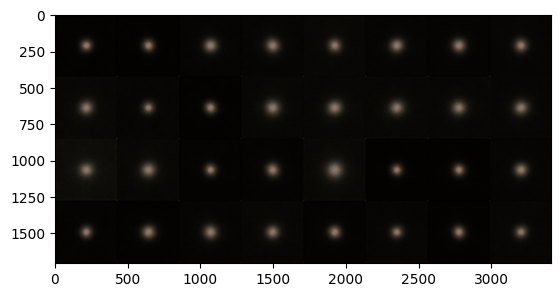

1e-06


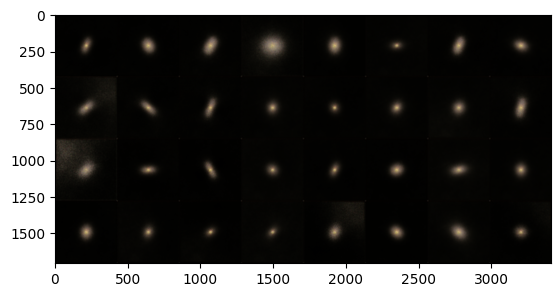

1e-07


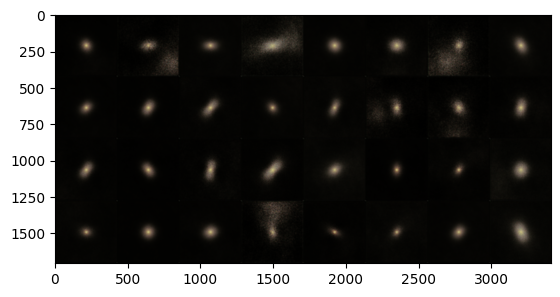

In [39]:
for alpha in (1,1e-1,1e-2,1e-4,1e-6,1e-7):
    model=torch.load(os.path.join('models',f'{model_name}_alpha_{alpha}.pt')).to('cpu')
    
    testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=10000)
    testloader = DataLoader(testset,batch_size=32, shuffle=True, num_workers=2)
    
    testimage=next(iter(testloader))
    
    testmu,testlogvar=model.encode(testimage)
    new_z=model.sample_z(testmu,testlogvar)
    newimage=model.decode(new_z)
    print(alpha)
    show_images(utils.make_grid(newimage))

## Test on reconstruction loss

### BCE

In [40]:
def ElboLoss(x, x_reconstructed, mu, sigma, alpha=1):
    criterion = F.binary_cross_entropy(x_reconstructed, x)
    KL_div = -0.5*torch.sum(1+sigma-mu**2-torch.exp(sigma))
    elbo = torch.mean(criterion + alpha * KL_div)
    return elbo

In [41]:
trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=10000)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

In [42]:
model = Conv_VAE(latent_dim=12).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
train_avg_loss = train_Conv(10,alpha=1e-6)

188it [00:22,  8.26it/s, loss=0.138]
188it [00:22,  8.48it/s, loss=0.135]
188it [00:22,  8.51it/s, loss=0.126]
188it [00:22,  8.43it/s, loss=0.148]
188it [00:22,  8.50it/s, loss=0.135]
188it [00:22,  8.24it/s, loss=0.13] 
188it [00:23,  8.00it/s, loss=0.127]
188it [00:22,  8.45it/s, loss=0.144]
188it [00:22,  8.43it/s, loss=0.129]
188it [00:22,  8.41it/s, loss=0.135]


In [44]:
torch.save(model, os.path.join('models',f'{model_name}_BCE.pt'))

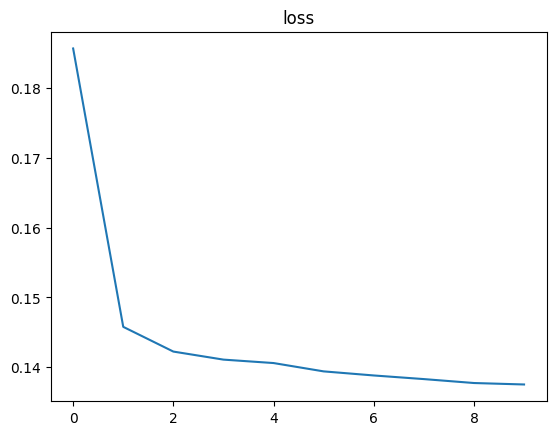

In [45]:
plt.plot(train_avg_loss)
plt.title('loss')
plt.show()

In [46]:
model=model.to('cpu')

In [47]:
testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=1000)
testloader = DataLoader(testset,batch_size=32, shuffle=True, num_workers=2)

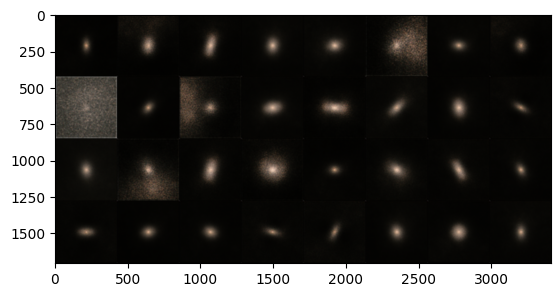

In [48]:
testimage=next(iter(testloader))
testmu,testlogvar=model.encode(testimage)
new_z=model.sample_z(testmu,testlogvar)
newimage=model.decode(new_z)
show_images(utils.make_grid(newimage))

### L1

In [49]:
def ElboLoss(x, x_reconstructed, mu, sigma, alpha=1):
    L1=nn.L1Loss()
    criterion = L1(x_reconstructed, x)
    KL_div = -0.5*torch.sum(1+sigma-mu**2-torch.exp(sigma))
    elbo = torch.mean(criterion + alpha * KL_div)
    return elbo

In [50]:
trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=10000)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

In [51]:
model = Conv_VAE(latent_dim=12).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
train_avg_loss = train_Conv(10,alpha=1e-6)

188it [00:23,  8.07it/s, loss=0.0342]
188it [00:22,  8.38it/s, loss=0.0226]
188it [00:22,  8.37it/s, loss=0.0236]
188it [00:22,  8.43it/s, loss=0.0203]
188it [00:22,  8.35it/s, loss=0.0194]
188it [00:22,  8.32it/s, loss=0.0203]
188it [00:22,  8.20it/s, loss=0.0178]
188it [00:22,  8.23it/s, loss=0.018] 
188it [00:22,  8.39it/s, loss=0.0179]
188it [00:22,  8.33it/s, loss=0.0214]


In [53]:
torch.save(model, os.path.join('models',f'{model_name}_L1.pt'))

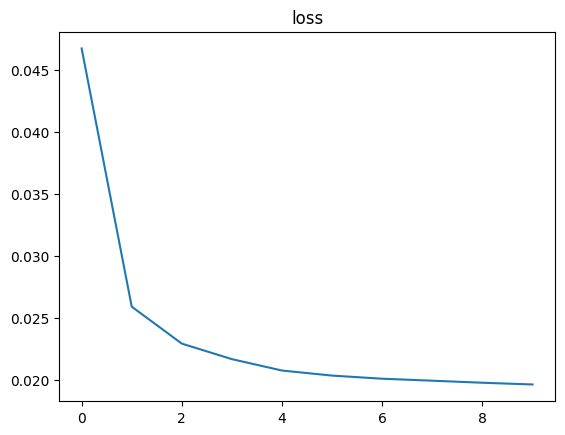

In [54]:
plt.plot(train_avg_loss)
plt.title('loss')
plt.show()

In [55]:
model=model.to('cpu')

In [56]:
testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=1000)
testloader = DataLoader(testset,batch_size=32, shuffle=True, num_workers=2)

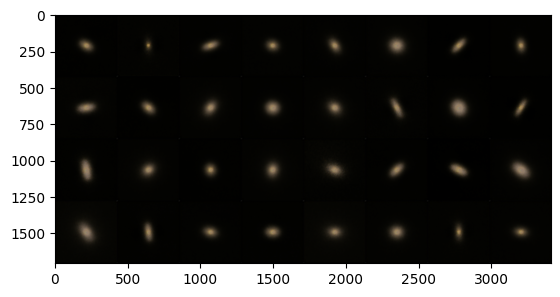

In [57]:
testimage=next(iter(testloader))
testmu,testlogvar=model.encode(testimage)
new_z=model.sample_z(testmu,testlogvar)
newimage=model.decode(new_z)
show_images(utils.make_grid(newimage))

### MSE


In [58]:
def ElboLoss(x, x_reconstructed, mu, sigma, alpha=1):
    MSE=nn.MSELoss()
    criterion = MSE(x_reconstructed, x)
    KL_div = -0.5*torch.sum(1+sigma-mu**2-torch.exp(sigma))
    elbo = torch.mean(criterion + alpha * KL_div)
    return elbo

In [60]:
trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=10000)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

model = Conv_VAE(latent_dim=12).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [61]:
train_avg_loss = train_Conv(10,alpha=1e-6)

188it [00:24,  7.69it/s, loss=0.00501]
188it [00:21,  8.59it/s, loss=0.00244]
188it [00:21,  8.77it/s, loss=0.00232]
188it [00:21,  8.66it/s, loss=0.00162]
188it [00:21,  8.59it/s, loss=0.00361]
188it [00:21,  8.56it/s, loss=0.00337]
188it [00:21,  8.55it/s, loss=0.00192]
188it [00:22,  8.51it/s, loss=0.0035] 
188it [00:21,  8.64it/s, loss=0.00266]
188it [00:21,  8.66it/s, loss=0.00171]


In [62]:
torch.save(model, os.path.join('models',f'{model_name}_MSE.pt'))

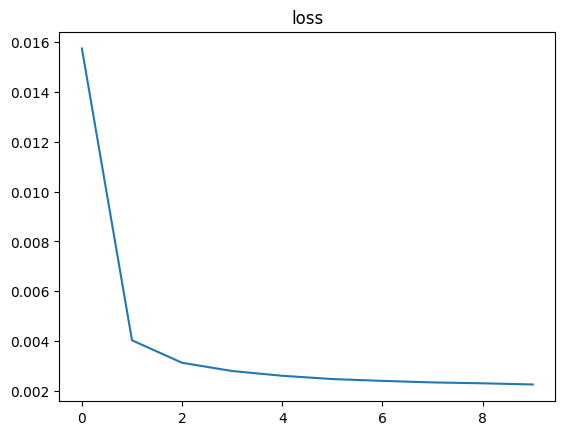

In [63]:
plt.plot(train_avg_loss)
plt.title('loss')
plt.show()

In [64]:
model=model.to('cpu')

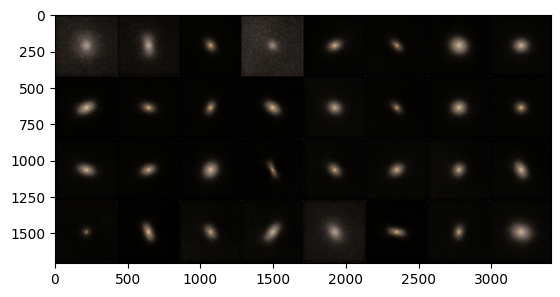

In [65]:
testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=1000)
testloader = DataLoader(testset,batch_size=32, shuffle=True, num_workers=2)

testimage=next(iter(testloader))
testmu,testlogvar=model.encode(testimage)
new_z=model.sample_z(testmu,testlogvar)
newimage=model.decode(new_z)
show_images(utils.make_grid(newimage))

## Test on KL_div

In [66]:
def ElboLoss(x, x_reconstructed, mu, sigma, alpha=1):
    criterion = F.binary_cross_entropy(x_reconstructed, x)
    KL=nn.KLDivLoss(reduction='batchmean')
    KL_div = KL(x_reconstructed,x)
    elbo = torch.mean(criterion + alpha * KL_div)
    return elbo

In [67]:
trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True, dataset_size=10000)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

model = Conv_VAE(latent_dim=12).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
train_avg_loss = train_Conv(10,alpha=1e-6)

188it [00:23,  8.07it/s, loss=0.0974]
188it [00:22,  8.18it/s, loss=0.0948]
188it [00:23,  8.07it/s, loss=0.0915]
188it [00:22,  8.21it/s, loss=0.0832]
188it [00:23,  8.05it/s, loss=0.08]  
188it [00:22,  8.23it/s, loss=0.0868]
188it [00:23,  8.13it/s, loss=0.0836]
188it [00:36,  5.09it/s, loss=0.0835]
188it [00:25,  7.46it/s, loss=0.0792]
188it [00:23,  8.16it/s, loss=0.0861]


In [69]:
torch.save(model, os.path.join('models',f'{model_name}_KL.pt'))

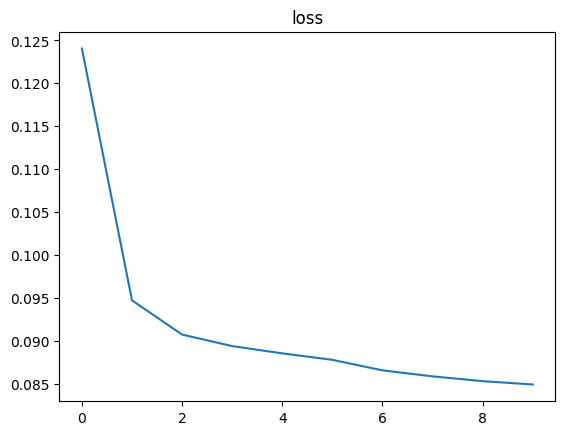

In [70]:
plt.plot(train_avg_loss)
plt.title('loss')
plt.show()

In [71]:
model=model.to('cpu')

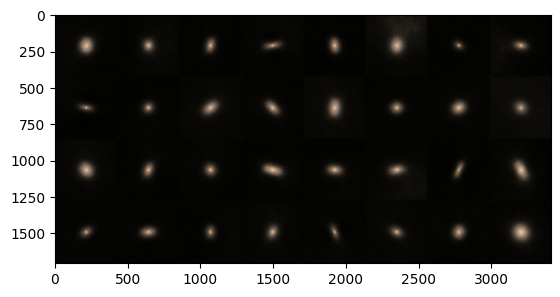

In [72]:
testset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor()]), train=False, dataset_size=1000)
testloader = DataLoader(testset,batch_size=32, shuffle=True, num_workers=2)

testimage=next(iter(testloader))
testmu,testlogvar=model.encode(testimage)
new_z=model.sample_z(testmu,testlogvar)
newimage=model.decode(new_z)
show_images(utils.make_grid(newimage))